Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

import networkx as nx
import networkx.algorithms.community as nx_comm

from sklearn.decomposition import PCA
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

random.seed(10)

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


Loading the data with necessary columns

In [2]:
data = pd.read_excel('opioid_data_merged_min.xlsx')

In [3]:
data

,WorldwideUniqueCaseIdentification,sex,Outcome,ATCode,PTCode,Frequency,age_group,weight_group,is_sideeffect
0,NL-002147023-NVSC2020NL143475,female,Recovered with sequelae,N02AX02,10012218,0.1,"(64.0, 90.0]",overweight,True
1,NL-002147023-NVSC2020NL143475,female,Recovered with sequelae,N02AX02,10075611,0.0,"(64.0, 90.0]",overweight,False
2,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10076493,0.0,"(64.0, 90.0]",overweight,False
3,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10009839,0.0,"(64.0, 90.0]",overweight,False
4,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10009839,0.0,"(64.0, 90.0]",overweight,False
...,...,...,...,...,...,...,...,...,...
6192,NL-TEVA-719924ROM,male,Recovered,N02AA05,10037660,0.0,"(64.0, 90.0]",normal,False
6193,NL-TEVA-719924ROM,male,Recovered,N02AA05,10062352,0.0,"(64.0, 90.0]",normal,False
6194,NL-TEVA-719924ROM,male,Recovered,N02AA05,10006002,0.0,"(64.0, 90.0]",normal,False
6195,NL-TEVA-719924ROM,male,Recovered,N02AA05,10046571,0.0,"(64.0, 90.0]",normal,False


Some transformations

In [4]:
data['WorldwideUniqueCaseIdentification'] = data.WorldwideUniqueCaseIdentification.astype(str)
data['age_group'] = data.age_group.astype(str)
data['PTCode'] = data.PTCode.astype(str)

Triple extraction

In [5]:
triples = []
for _, row in data.iterrows():
        
    # Weight group info
    weight_group = (row['WorldwideUniqueCaseIdentification'], "hasWeightGroup", row['weight_group'])

    # Age group info
    age_group = (row['WorldwideUniqueCaseIdentification'], "hasAgeGroup", row['age_group'])

    # Gender info
    sex = (row['WorldwideUniqueCaseIdentification'], "hasGender", row['sex'])

    #Outcome
    outcome = (row['WorldwideUniqueCaseIdentification'], "hasOutcome", row['Outcome'])

    #Symptom
    symptom = (row['WorldwideUniqueCaseIdentification'], "hasSymptom", row['PTCode'])

    #Drug
    drug = (row['WorldwideUniqueCaseIdentification'], "isGivenDrug", row['ATCode'])

    #Frequency
    frequency = (row['PTCode'], "hasFrequency", row['Frequency'])    
    
    #Side effect
    if row['is_sideeffect'] == True:
        side_effect = (row['WorldwideUniqueCaseIdentification'], "hasSideEffect", row['PTCode'])
    else:
        side_effect = (row['WorldwideUniqueCaseIdentification'], "hasSideEffect", "None")

    triples.extend((weight_group, age_group, sex, outcome, symptom, drug, frequency, side_effect))

This is how they look in a dataframe:

In [6]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df = triples_df.drop_duplicates()
triples_df[(triples_df.subject=="NL-TEVA-719924ROM")]

,subject,predicate,object
49520,NL-TEVA-719924ROM,hasWeightGroup,normal
49521,NL-TEVA-719924ROM,hasAgeGroup,"(64.0, 90.0]"
49522,NL-TEVA-719924ROM,hasGender,male
49523,NL-TEVA-719924ROM,hasOutcome,Recovered
49524,NL-TEVA-719924ROM,hasSymptom,10046571
49525,NL-TEVA-719924ROM,isGivenDrug,N02AA05
49527,NL-TEVA-719924ROM,hasSideEffect,None
49532,NL-TEVA-719924ROM,hasSymptom,10047700
49540,NL-TEVA-719924ROM,hasSymptom,10037660
49548,NL-TEVA-719924ROM,hasSymptom,10062352


Train-test split

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=7930)

In [8]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (41646, 3)
Test set size:  (7930, 3)


We choose ComplEx as our Knowledge Graph Embedding model:

In [9]:
from ampligraph.latent_features.models import ScoringBasedEmbeddingModel
    
# Initialize a ComplEx neural embedding model: the embedding size is k,
# eta specifies the number of corruptions to generate per each positive,
# scoring_type determines the scoring function of the embedding model.
model = ScoringBasedEmbeddingModel(k=150,
                                   eta=10,
                                   scoring_type='ComplEx')

Compile model

In [10]:
import tensorflow as tf

from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = get_loss('pairwise', {'margin': 0.5})
regularizer = get_regularizer('LP', {'p': 2, 'lambda': 1e-5})

# Compilation of the model
model.compile(loss=loss,
              optimizer='adam',
              entity_relation_regularizer=regularizer,
              entity_relation_initializer='glorot_uniform')

Train model

In [11]:
# Fit the model on training and validation set

model.fit(X_train,
          batch_size=int(X_train.shape[0] / 10), # use 1/10 of the training set as batch size
          epochs=200,                    # Number of training epochs
          verbose=True                  # Enable stdout messages
          )

Epoch 1/200
12/12 [==============================] - 12s 990ms/step - loss: 18898.6113
Epoch 2/200
12/12 [==============================] - 4s 357ms/step - loss: 18829.7910
Epoch 3/200
12/12 [==============================] - 4s 326ms/step - loss: 18720.4707
Epoch 4/200
12/12 [==============================] - 4s 330ms/step - loss: 18535.0352
Epoch 5/200
12/12 [==============================] - 4s 324ms/step - loss: 18224.8418
Epoch 6/200
12/12 [==============================] - 4s 324ms/step - loss: 17724.5703
Epoch 7/200
12/12 [==============================] - 4s 323ms/step - loss: 16956.4648
Epoch 8/200
12/12 [==============================] - 4s 323ms/step - loss: 15937.3945
Epoch 9/200
12/12 [==============================] - 4s 317ms/step - loss: 14863.9600
Epoch 10/200
12/12 [==============================] - 4s 324ms/step - loss: 13870.2158
Epoch 11/200
12/12 [==============================] - 4s 319ms/step - loss: 12984.0059
Epoch 12/200
12/12 [==============================]

An additional step when evaluating KGEs: Define a filter so that no negative statements generated by the corruption procedure are actually positives.

In [12]:
filter = {'test': np.concatenate([X_train, X_test])}

Evaluate model

In [14]:
ranks = model.evaluate(X_test,
                       use_filter=filter,
                       corrupt_side='s,o',
                       verbose=True)

249/249 [==============================] - 42s 167ms/step


We used the mrr_score (mean reciprocal rank) and hits_at_n_score functions to evaluate the quality of our predictions:

In [15]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.88
MR: 37.32
Hits@10: 0.90
Hits@3: 0.88
Hits@1: 0.87


Get embedings for all patients

In [16]:
patients = data.WorldwideUniqueCaseIdentification.unique()
patient_embeddings = dict(zip(patients, model.get_embeddings(patients)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [17]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in patient_embeddings.values()]))

Find the ideal k-value

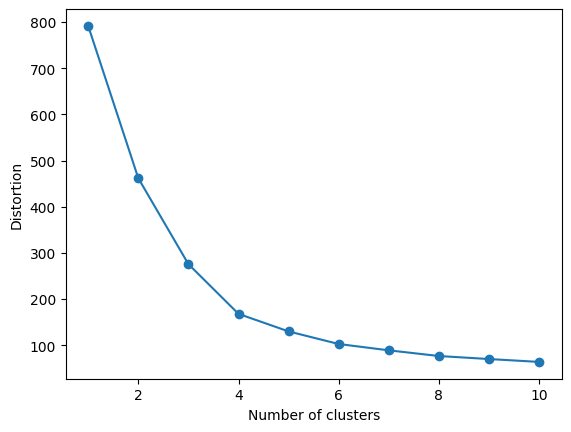

In [18]:
from sklearn.cluster import KMeans

WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d )
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

We now cluster the teams embeddings on its original 200-dimensional space:

In [19]:
from ampligraph.discovery import find_clusters

clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(patients, model, clustering_algorithm, mode='e')

print(len(clusters))
print(len(patients))

1584
1584


Store the clusters for later use

In [20]:
# Cluster-patient dictionary

results = dict(zip(clusters, patients))

with open("clusters.txt", 'w') as f: 
    for key, value in results.items(): 
        f.write('%s:%s\n' % (key, value))

Visualization

In [21]:
plot_df = pd.DataFrame({"patients": patients, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [22]:
# Plot 2D embeddings
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df,
                         x="embedding1", y="embedding2", hue=hue)

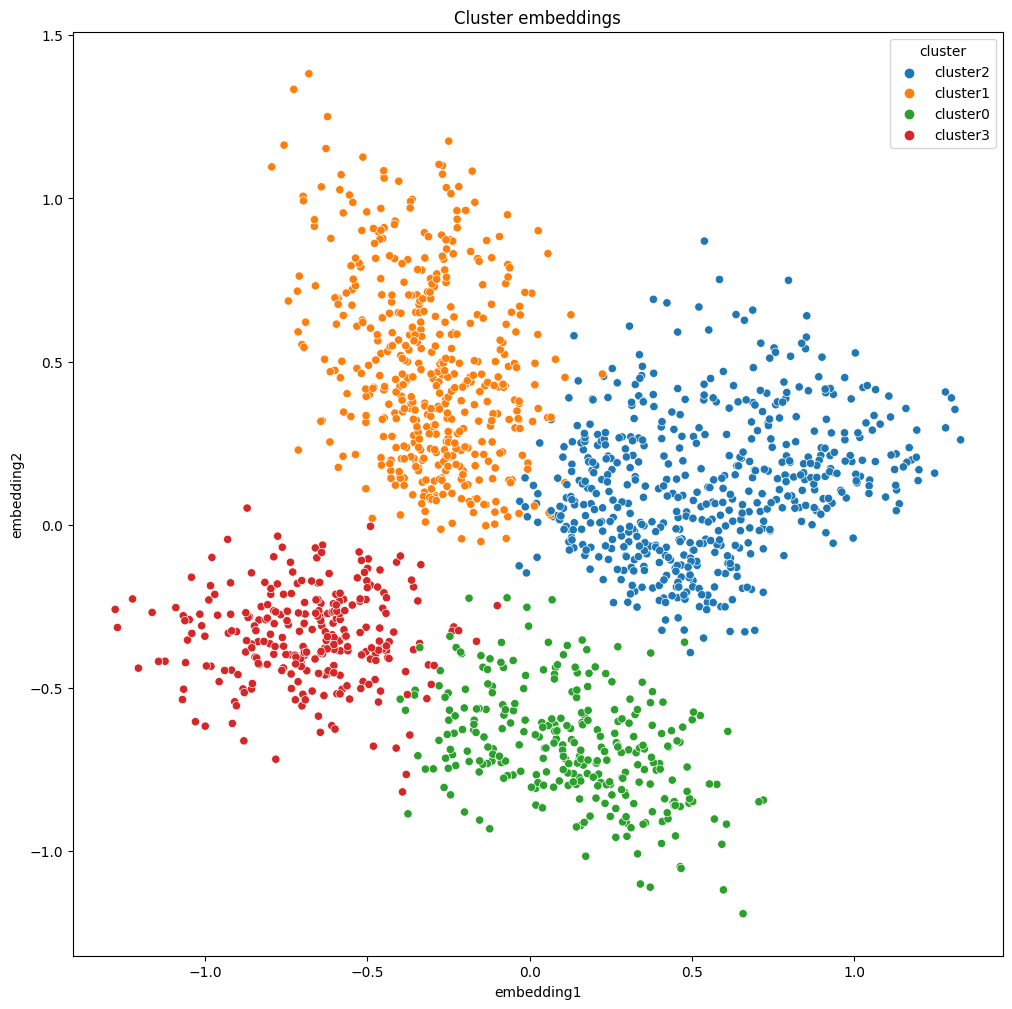

In [23]:
plot_clusters("cluster")